## Offer Analysis - Individual vs. Shared Type
[Analytics ticket here](https://banksimple.atlassian.net/browse/AL-981)

In [1]:
import numpy as np
import seaborn as sns
from scipy import stats
from datetime import date
from simply import redshift
from pandas import DataFrame
from matplotlib import pyplot as plt

### Population:
- Every account paid out for the offer. 
- Broken between shared vs. indie type
- 1 row with balance for each day post hold by deadline

In [6]:
account_retention = redshift("""
with balance_hold_by_deadline as (
select
    foa.account_ref,
    offer_month,
    foa.type,
    case when offer_month = '2019-07-01' then '2019-10-31'::date else '2019-12-31'::date end as hold_by_date,
    ledger_balance_eod as hold_by_balance,
    da.close_date
from fact_offer_account foa
join fact_account_day fad on foa.account_ref = fad.account_ref
join dim_account da on fad.account_ref = da.account_ref
where offer_month in ('2019-07-01','2019-08-01','2019-09-01')
    and fad.date = hold_by_date
    and foa.type ilike '%PROTECTED'
    and paid_out = true
    ),

post_hold_deadline as (
select
    foa.account_ref,
    foa.offer_month,
    case when foa.offer_month = '2019-07-01' then '2019-10-31'::date else '2019-12-31'::date end as hold_by_date,
    hold_by_balance,
    foa.type,
    date,
    datediff(day,hold_by_date,date) as days_since_hold_deadline,
    payout_amount,
    ledger_balance_eod as ledger_balance_eod,
    case when 10000 <= ledger_balance_eod then 1 else 0 end maintained_balance_flag,
    (ledger_balance_eod - hold_by_balance) as balance_diff
from fact_offer_account foa
join balance_hold_by_deadline b on foa.account_ref = b.account_ref
join fact_account_day fad on foa.account_ref = fad.account_ref
where foa.offer_month in ('2019-07-01','2019-08-01','2019-09-01')
    and fad.date >= hold_by_date
    and fad.date < current_date
    and foa.type ilike '%PROTECTED'
    and paid_out = true --only look at folks who were paid out
    and days_since_hold_deadline = 60
    )

select
    b.account_ref,
    b.hold_by_date,
    close_date,
    b.offer_month,
    b.hold_by_balance,
    b.type,
    date,
    isnull(days_since_hold_deadline,60) as days_since_hold_deadline,
    payout_amount,
    isnull(ledger_balance_eod,0) as ledger_balance_eod,
    isnull(maintained_balance_flag,0) as maintained_balance_flag,
    isnull(balance_diff,(b.hold_by_balance*-1)) as balance_diff
from balance_hold_by_deadline b
left join post_hold_deadline as p on b.account_ref = p.account_ref
;
""")

In [7]:
account_retention.describe()

,hold_by_balance,days_since_hold_deadline,payout_amount,ledger_balance_eod,maintained_balance_flag,balance_diff
count,4806.000000,4806.0,4297.000000,4806.000000,4806.000000,4806.000000
mean,14958.684771,60.0,235.268792,11369.538019,0.516854,-3589.146752
std,21919.641741,0.0,35.445799,22939.099618,0.499768,17800.305918
min,0.010000,60.0,150.000000,0.000000,0.000000,-380064.840000
25%,10037.840000,60.0,250.000000,1.060000,0.000000,-10044.145000
50%,10057.160000,60.0,250.000000,10232.835000,1.000000,-2809.640000
75%,10351.760000,60.0,250.000000,10528.055000,1.000000,298.670000
max,754031.010000,60.0,250.000000,457192.390000,1.000000,303442.560000


In [8]:
account_retention.head()

,account_ref,hold_by_date,close_date,offer_month,hold_by_balance,type,date,days_since_hold_deadline,payout_amount,ledger_balance_eod,maintained_balance_flag,balance_diff
0,07bd28a7-9c59-3555-a35c-77101796b01a,2019-12-31,None,2019-09-01,11160.05,INDIVIDUAL_PROTECTED,2020-02-29,60,150.0,11436.16,1,276.11
1,27bd8424-0d11-3b65-a3b1-ac4da7435d6c,2019-12-31,None,2019-08-01,10055.43,SHARED_PROTECTED,2020-02-29,60,250.0,10354.10,1,298.67
2,2ef76706-cf30-37be-af70-96f850bee901,2019-10-31,None,2019-07-01,10026.99,INDIVIDUAL_PROTECTED,2019-12-30,60,250.0,0.00,0,-10026.99
3,331f2580-4fdb-37dd-a624-2b1370c28a29,2019-12-31,None,2019-08-01,10656.02,INDIVIDUAL_PROTECTED,2020-02-29,60,250.0,9.13,0,-10646.89
4,5e1353ea-3603-3eca-a37d-4e914680d2ba,2019-10-31,None,2019-07-01,10533.23,INDIVIDUAL_PROTECTED,2019-12-30,60,250.0,12271.14,1,1737.91


In [9]:
#Currently it has been 60 days since the hold deadline for August and September. Use day 60 for balance retention

retention_day_60 = account_retention[account_retention.days_since_hold_deadline == 60]

#yesterday_retention = account_retention[account_retention.date == date(2020, 3, 1)]
#type('2020-03-01')
#type(account_retention.date[0])
#account_level_retention.date
#type(account_level_retention.date)

In [10]:
retention_day_60.head()

,account_ref,hold_by_date,close_date,offer_month,hold_by_balance,type,date,days_since_hold_deadline,payout_amount,ledger_balance_eod,maintained_balance_flag,balance_diff
0,07bd28a7-9c59-3555-a35c-77101796b01a,2019-12-31,None,2019-09-01,11160.05,INDIVIDUAL_PROTECTED,2020-02-29,60,150.0,11436.16,1,276.11
1,27bd8424-0d11-3b65-a3b1-ac4da7435d6c,2019-12-31,None,2019-08-01,10055.43,SHARED_PROTECTED,2020-02-29,60,250.0,10354.10,1,298.67
2,2ef76706-cf30-37be-af70-96f850bee901,2019-10-31,None,2019-07-01,10026.99,INDIVIDUAL_PROTECTED,2019-12-30,60,250.0,0.00,0,-10026.99
3,331f2580-4fdb-37dd-a624-2b1370c28a29,2019-12-31,None,2019-08-01,10656.02,INDIVIDUAL_PROTECTED,2020-02-29,60,250.0,9.13,0,-10646.89
4,5e1353ea-3603-3eca-a37d-4e914680d2ba,2019-10-31,None,2019-07-01,10533.23,INDIVIDUAL_PROTECTED,2019-12-30,60,250.0,12271.14,1,1737.91


In [11]:
retention_day_60.groupby(['type']).mean().reset_index()
#Rate at which accounts still have a balance of $10,000 on day 60 by type

,type,hold_by_balance,days_since_hold_deadline,payout_amount,ledger_balance_eod,maintained_balance_flag,balance_diff
0,INDIVIDUAL_PROTECTED,14481.001755,60.0,235.202312,11038.939836,0.520509,-3442.061918
1,SHARED_PROTECTED,16905.150598,60.0,235.526316,12715.626390,0.502623,-4189.524208


In [12]:
account_counts_day_60 = retention_day_60[['type','offer_month','account_ref','balance_diff']].groupby(['type','offer_month']).count().reset_index()
account_counts_day_60

,type,offer_month,account_ref,balance_diff
0,INDIVIDUAL_PROTECTED,2019-07-01,1627,1627
1,INDIVIDUAL_PROTECTED,2019-08-01,1670,1670
2,INDIVIDUAL_PROTECTED,2019-09-01,555,555
3,SHARED_PROTECTED,2019-07-01,369,369
4,SHARED_PROTECTED,2019-08-01,451,451
5,SHARED_PROTECTED,2019-09-01,133,133


In [13]:
account_maintain_balance_day_60 = retention_day_60[['type','offer_month','maintained_balance_flag','balance_diff']].groupby(['type','offer_month']).mean().reset_index()
#Rate at which accounts still have a balance of $10,000 on day 60 by type and offer month

In [14]:
maintain_balance_rate = account_maintain_balance_day_60.join(account_counts_day_60[['account_ref']], lsuffix='_caller', rsuffix='_other')
maintain_balance_rate
#Note the reason we need to call the 'account_ref' is because that is the only column we need to pull in to join. Otherwise we end up with repeat columns

,type,offer_month,maintained_balance_flag,balance_diff,account_ref
0,INDIVIDUAL_PROTECTED,2019-07-01,0.529195,-1345.455181,1627
1,INDIVIDUAL_PROTECTED,2019-08-01,0.493413,-5348.672317,1670
2,INDIVIDUAL_PROTECTED,2019-09-01,0.576577,-3851.322811,555
3,SHARED_PROTECTED,2019-07-01,0.498645,-2352.408184,369
4,SHARED_PROTECTED,2019-08-01,0.465632,-5883.841907,451
5,SHARED_PROTECTED,2019-09-01,0.639098,-3541.092105,133


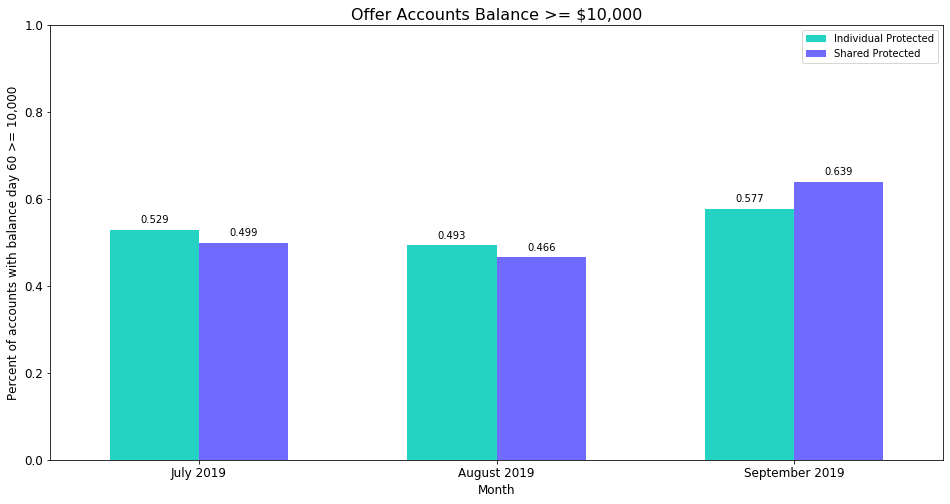

In [15]:
fig, ax = plt.subplots(figsize=(16,8))

indie = maintain_balance_rate[maintain_balance_rate.type == 'INDIVIDUAL_PROTECTED']
shared = maintain_balance_rate[maintain_balance_rate.type == 'SHARED_PROTECTED']

month1 = indie.index
month2 = shared.index

labels = ['July 2019','August 2019','September 2019']

width = 0.30
ax.set_xticks(indie.index)
ax.set_xticklabels(labels)

p1 = plt.bar(month1-width/2, indie.maintained_balance_flag, width, color = '#24D3C1')
p2 = plt.bar(month2-(3-width/2), shared.maintained_balance_flag, width, color = '#706AFE')
#p2 = plt.bar(month2-2.85, shared.maintained_balance_flag, width, color = '#706AFE')

plt.xlim(-0.5,2.5)
plt.ylim(0,1)
plt.xlabel('Month', fontsize = 12)
plt.xticks(fontsize = 12)
plt.ylabel('Percent of accounts with balance day 60 >= 10,000', fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Offer Accounts Balance >= $10,000', fontsize = 16)
plt.legend(['Individual Protected','Shared Protected'], fontsize=10)
plt.grid(False)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    textcoords="offset points",
                    xytext=(0,5),
                    ha='center', va='bottom')

autolabel(p1)
autolabel(p2)

#plt.axvline(p1_x_value)

plt.show()

In [16]:
p1_x_value = p1[0].get_x()

In [17]:
for b in p1:
    print(b)

Rectangle(xy=(-0.3, 0), width=0.3, height=0.529195, angle=0)
Rectangle(xy=(0.7, 0), width=0.3, height=0.493413, angle=0)
Rectangle(xy=(1.7, 0), width=0.3, height=0.576577, angle=0)


In [18]:
s = 'one two three {}'

In [19]:
'one two three {}'.format('four')

'one two three four'

In [20]:
s.format('four')

'one two three four'

In [21]:
str(round(p1[0].get_height(),3))

'0.529'

In [22]:
'{}'.format(p1[0].get_height())

'0.5291948371235402'

#### Ignore the next 6 lines as they were just for practice
-----------

In [23]:
#account_maintain_balance.join(account_counts.set_index(['type','offer_month']), on=['type','offer_month'], lsuffix='_caller', rsuffix='_other')


In [24]:
#help(account_maintain_balance.join)

In [25]:
a = 'string'

In [26]:
a.split

<function str.split(sep=None, maxsplit=-1)>

In [27]:
a.split()

['string']

In [28]:
#help(a.split())

------
#### Resume Analysis

In [29]:
retention_day_60.reset_index().head()

,index,account_ref,hold_by_date,close_date,offer_month,hold_by_balance,type,date,days_since_hold_deadline,payout_amount,ledger_balance_eod,maintained_balance_flag,balance_diff
0,0,07bd28a7-9c59-3555-a35c-77101796b01a,2019-12-31,None,2019-09-01,11160.05,INDIVIDUAL_PROTECTED,2020-02-29,60,150.0,11436.16,1,276.11
1,1,27bd8424-0d11-3b65-a3b1-ac4da7435d6c,2019-12-31,None,2019-08-01,10055.43,SHARED_PROTECTED,2020-02-29,60,250.0,10354.10,1,298.67
2,2,2ef76706-cf30-37be-af70-96f850bee901,2019-10-31,None,2019-07-01,10026.99,INDIVIDUAL_PROTECTED,2019-12-30,60,250.0,0.00,0,-10026.99
3,3,331f2580-4fdb-37dd-a624-2b1370c28a29,2019-12-31,None,2019-08-01,10656.02,INDIVIDUAL_PROTECTED,2020-02-29,60,250.0,9.13,0,-10646.89
4,4,5e1353ea-3603-3eca-a37d-4e914680d2ba,2019-10-31,None,2019-07-01,10533.23,INDIVIDUAL_PROTECTED,2019-12-30,60,250.0,12271.14,1,1737.91


### Chi Square Test
Measure the difference between individual vs. shared accounts to determine if their balance is still >= $10,000

In [30]:
individual_retention_day_60 = retention_day_60[retention_day_60.type =='INDIVIDUAL_PROTECTED']
shared_retention_day_60 = retention_day_60[retention_day_60.type =='SHARED_PROTECTED']

obs = np.array([[individual_retention_day_60[individual_retention_day_60.maintained_balance_flag == 1].account_ref.count(),individual_retention_day_60[individual_retention_day_60.maintained_balance_flag == 0].account_ref.count()],
               [shared_retention_day_60[shared_retention_day_60.maintained_balance_flag == 1].account_ref.count(),shared_retention_day_60[shared_retention_day_60.maintained_balance_flag == 0].account_ref.count()]])
chi2, p, dof, expected = stats.chi2_contingency(obs)

print(p)

# obs = np.array([
#                 [10, 10, 20], 
#                 [20, 20, 20]
#                 ])
#chi2_contingency(obs)

0.340543077285659


In [31]:
#help(np.array)

### Understand difference between balance between hold deadline to day 60
Get the difference between day 0 and day 60 of balances. Then run a t-test on that difference

In [32]:
individual_retention_day_60.describe()

,hold_by_balance,days_since_hold_deadline,payout_amount,ledger_balance_eod,maintained_balance_flag,balance_diff
count,3852.000000,3852.0,3460.000000,3852.000000,3852.000000,3852.000000
mean,14481.001755,60.0,235.202312,11038.939836,0.520509,-3442.061918
std,20856.233225,0.0,35.512839,22090.810744,0.499644,17490.512024
min,0.740000,60.0,150.000000,0.000000,0.000000,-380064.840000
25%,10037.847500,60.0,250.000000,1.590000,0.000000,-10044.037500
50%,10057.640000,60.0,250.000000,10234.550000,1.000000,-1962.790000
75%,10285.217500,60.0,250.000000,10513.015000,1.000000,298.670000
max,754031.010000,60.0,250.000000,457192.390000,1.000000,303442.560000


### T Test - Determine difference in balance change

In [33]:
tt = stats.ttest_ind(individual_retention_day_60.balance_diff, shared_retention_day_60.balance_diff, nan_policy='omit')

In [34]:
tt.pvalue

0.245865450868512

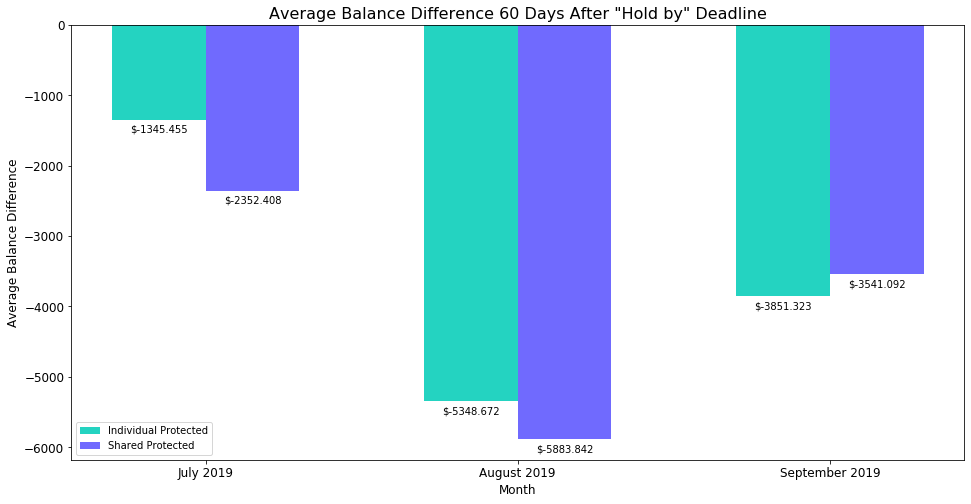

In [35]:
fig, ax = plt.subplots(figsize=(16,8))

indie = maintain_balance_rate[maintain_balance_rate.type == 'INDIVIDUAL_PROTECTED']
shared = maintain_balance_rate[maintain_balance_rate.type == 'SHARED_PROTECTED']

month1 = indie.index
month2 = shared.index

labels = ['July 2019','August 2019','September 2019']

width = 0.30
ax.set_xticks(indie.index)
ax.set_xticklabels(labels)

p1 = plt.bar(month1-width/2, indie.balance_diff, width, color = '#24D3C1')
p2 = plt.bar(month2-(3-width/2), shared.balance_diff, width, color = '#706AFE')
#p2 = plt.bar(month2-2.85, shared.maintained_balance_flag, width, color = '#706AFE')

#plt.xlim(-0.5,2.5)
#plt.ylim(0,1)
plt.xlabel('Month', fontsize = 12)
plt.xticks(fontsize = 12)
plt.ylabel('Average Balance Difference', fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Average Balance Difference 60 Days After "Hold by" Deadline', fontsize = 16)
plt.legend(['Individual Protected','Shared Protected'], fontsize=10)
plt.grid(False)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('${}'.format(round(height,3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    textcoords="offset points",
                    xytext=(0,-15),
                    ha='center', va='bottom')

autolabel(p1)
autolabel(p2)

#plt.axvline(p1_x_value)

plt.show()